In [2]:
!uv add rasterio

Resolved 133 packages in 3.11s
Prepared 4 packages in 29.33s
Installed 4 packages in 222ms
 + affine==2.4.0
 + click-plugins==1.1.1.2
 + cligj==0.7.2
 + rasterio==1.4.4


In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def sentinel_read(sentinel_timestamp):
    sentinel_dir = os.path.join(root_dir, sentinel_timestamp)
    bands = glob.glob(os.path.join(sentinel_dir, '**', '*.jp2'), recursive=True)

    band_arrays = {}
    band_sources = {}

    for band_file in bands:
        fname = os.path.basename(band_file)

        if fname.endswith('TCI.jp2'):
            continue

        band_name = fname.split('_')[-1].replace('.jp2', '')

        src = rasterio.open(band_file)
        arr = src.read(1)

        # initialize lists
        if band_name not in band_arrays:
            band_arrays[band_name] = []
            band_sources[band_name] = []

        band_arrays[band_name].append(arr)
        band_sources[band_name].append(src)

    return sentinel_dir, band_arrays, band_sources


In [10]:
root_dir = './'
sentinel_dir, band_arrays, band_sources = sentinel_read(sentinel_timestamp="data")

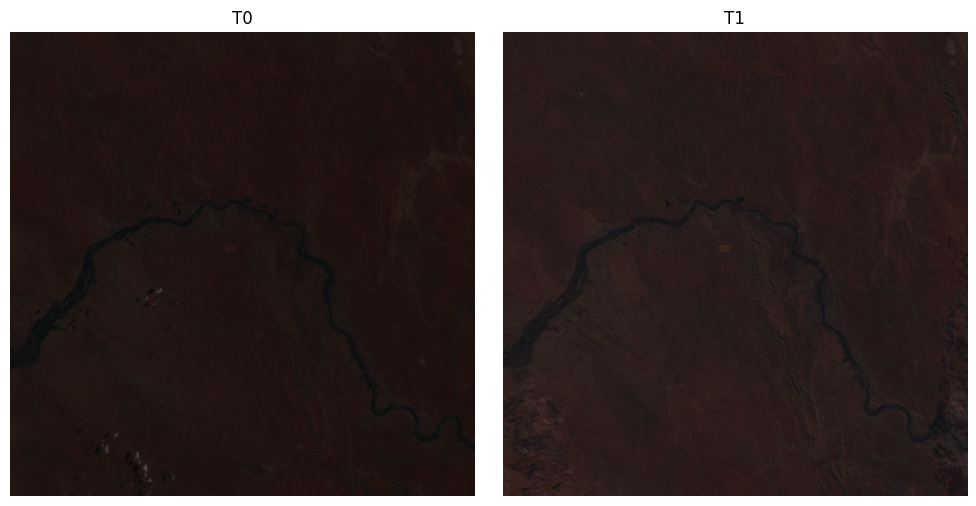

In [24]:
n = len(band_arrays['B04'])  # number of timestamps

fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for idx, ax in enumerate(axes):

    r = band_arrays['B04'][idx][::5, ::5]
    g = band_arrays['B03'][idx][::5, ::5]
    b = band_arrays['B02'][idx][::5, ::5]

    rgb = np.dstack([r,g,b]).astype(np.float32)
    rgb /= rgb.max()

    ax.imshow(rgb)
    ax.set_title(f"T{idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

def visualize_index_lowmem(band_sources, index_type="NDVI", downsample_factor=10, band_labels=None):
    """
    Memory-efficient visualization of satellite indices.
    
    Parameters:
        band_sources: dict of rasterio DatasetReaders per band per timestamp
        index_type: "NDVI", "NDWI", "NDBI", "SAVI"
        downsample_factor: int, reduce resolution to save memory
        band_labels: optional list of titles per timestamp
    """
    n = len(band_sources['B04'])
    
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1:
        axes = [axes]
    
    for idx, ax in enumerate(axes):
        # Determine output shape after downsampling
        src_red = band_sources['B04'][idx]
        out_shape = (
            src_red.height // downsample_factor,
            src_red.width // downsample_factor
        )
        
        # Read & downsample directly from disk (10m bands)
        red = src_red.read(1, out_shape=out_shape).astype(np.float32)
        green = band_sources['B03'][idx].read(1, out_shape=out_shape).astype(np.float32)
        nir = band_sources['B08'][idx].read(1, out_shape=out_shape).astype(np.float32)
        
        # Read & resample SWIR if needed (20m band)
        swir = None
        if index_type.upper() == "NDBI":
            src_swir = band_sources['B11'][idx]
            swir = src_swir.read(
                1,
                out_shape=out_shape,
                resampling=Resampling.bilinear
            ).astype(np.float32)
        
        # compute index
        itype = index_type.upper()
        if itype == "NDVI":
            img = (nir - red) / (nir + red + 1e-10)
            cmap = "RdYlGn"
        elif itype == "NDWI":
            img = (green - nir) / (green + nir + 1e-10)
            cmap = "Blues"
        elif itype == "NDBI":
            img = (swir - nir) / (swir + nir + 1e-10)
            cmap = "gray"
        elif itype == "SAVI":
            L = 0.5
            img = ((nir - red) * (1 + L)) / (nir + red + L + 1e-10)
            cmap = "RdYlGn"
        else:
            raise ValueError(f"Unknown index_type: {index_type}")
        
        # plot
        ax.imshow(img, cmap=cmap)
        title = f"T{idx}" if band_labels is None else band_labels[idx]
        ax.set_title(title)
        ax.axis('off')
    
    fig.colorbar(ax.images[0], ax=axes, fraction=0.03, pad=0.04, label=itype)
    plt.tight_layout()
    plt.show()


C:\Users\PSA\AppData\Local\Temp\ipykernel_8000\1236659483.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


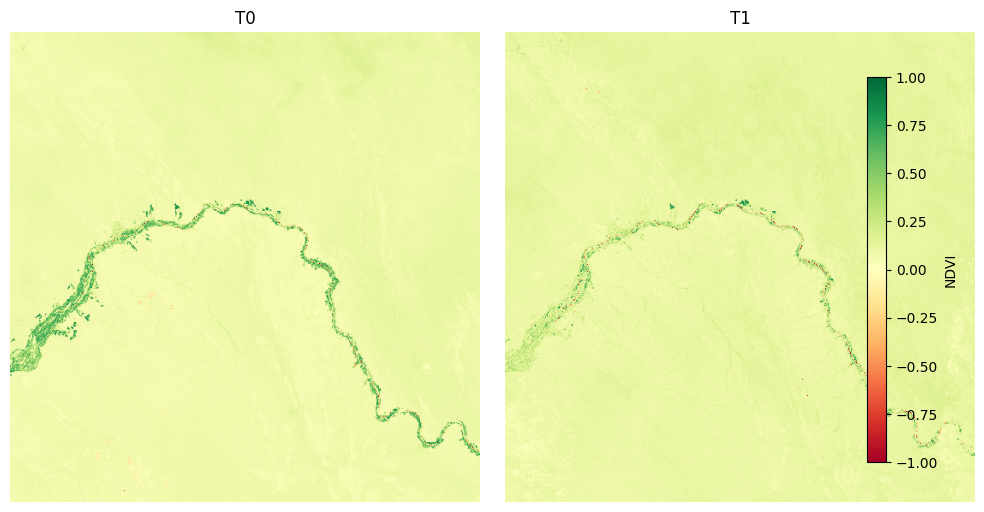

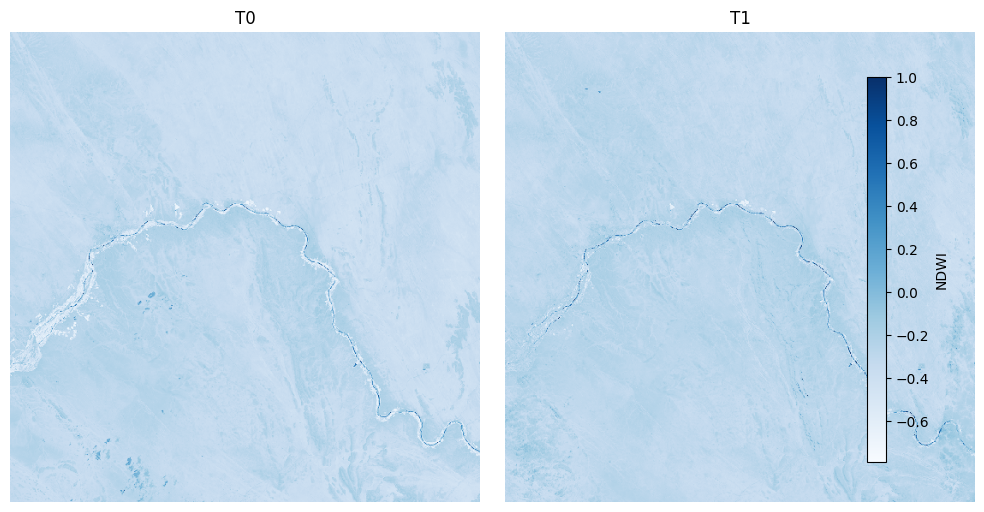

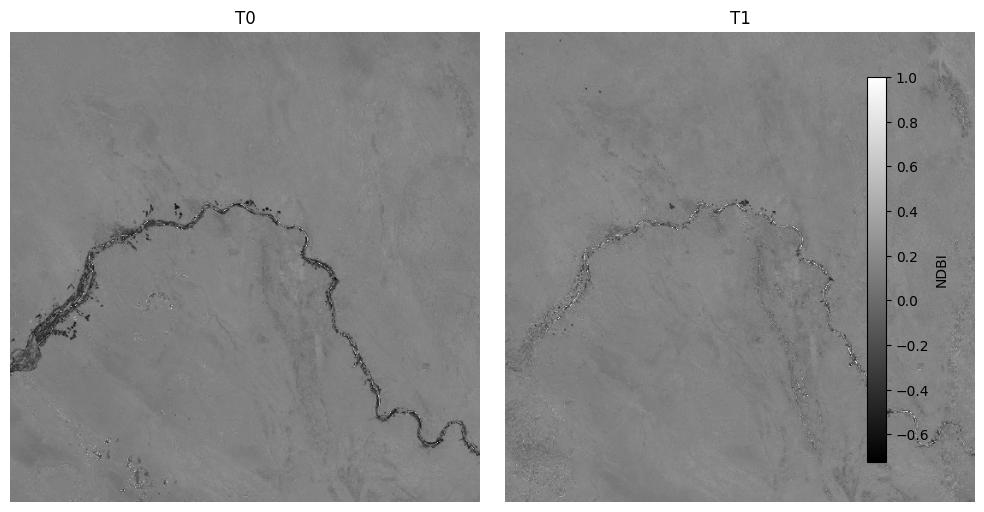

In [36]:
# Example usage:
visualize_index_lowmem(band_sources, index_type="NDVI", downsample_factor=20)
visualize_index_lowmem(band_sources, index_type="NDWI", downsample_factor=20)
visualize_index_lowmem(band_sources, index_type="NDBI", downsample_factor=20)
